### Анализ СМС трафика телеком оператора
У нас есть данные по СМС трафику телеком оператора за январь 2023 года с интервалом 15 минут to do (сделать красивое описание
)


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore')

In [66]:
data = pd.read_csv('data/telecom_sms_data.csv', parse_dates=['Event time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event time  2976 non-null   datetime64[ns]
 1   label       2976 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.6 KB


In [67]:
# отсортируем по дате (чтобы данные были упорядочены по времени)
data.sort_values(by='Event time', ascending=True)

,Event time,label
0,2023-01-01 00:00:00,704
1,2023-01-01 00:15:00,213
2,2023-01-01 00:30:00,126
3,2023-01-01 00:45:00,167
4,2023-01-01 01:00:00,210
...,...,...
2971,2023-01-31 22:45:00,287
2972,2023-01-31 23:00:00,295
2973,2023-01-31 23:15:00,225
2974,2023-01-31 23:30:00,253


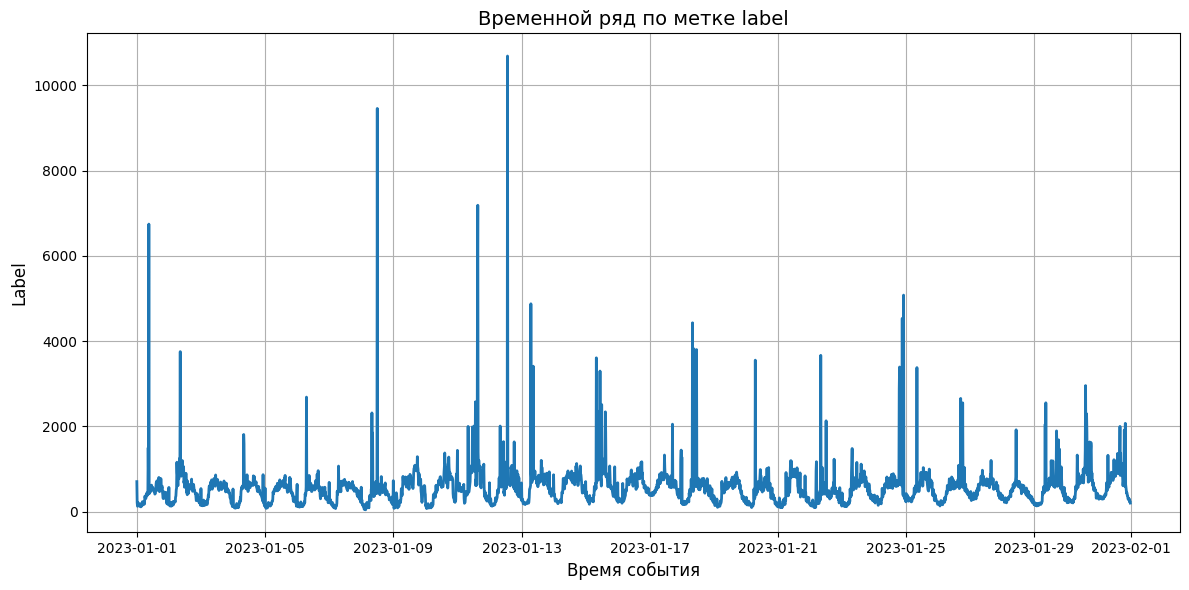

In [68]:
# строим график
plt.figure(figsize=(12, 6))
plt.plot(data['Event time'], data['label'], linestyle='-', linewidth=2)

# оформляем
plt.title('Временной ряд по метке label', fontsize=14)
plt.xlabel('Время события', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

### Декомпозиция временного ряда

Декомпозиция временного ряда нужна для того, чтобы разделить данные на несколько основных компонент:
- Trend (тренд) — долгосрочное изменение уровня ряда.
- Seasonality (сезонность) — повторяющиеся паттерны (день недели, время суток и т.д.).
- Residuals (остатки) — случайные колебания, шум.

Такой подход помогает лучше понять структуру данных, выявить закономерности, а также подготовить ряд к моделированию: корректно учитывать сезонность, тренд и отсекать шум.


In [69]:
data.set_index('Event time', inplace=True)

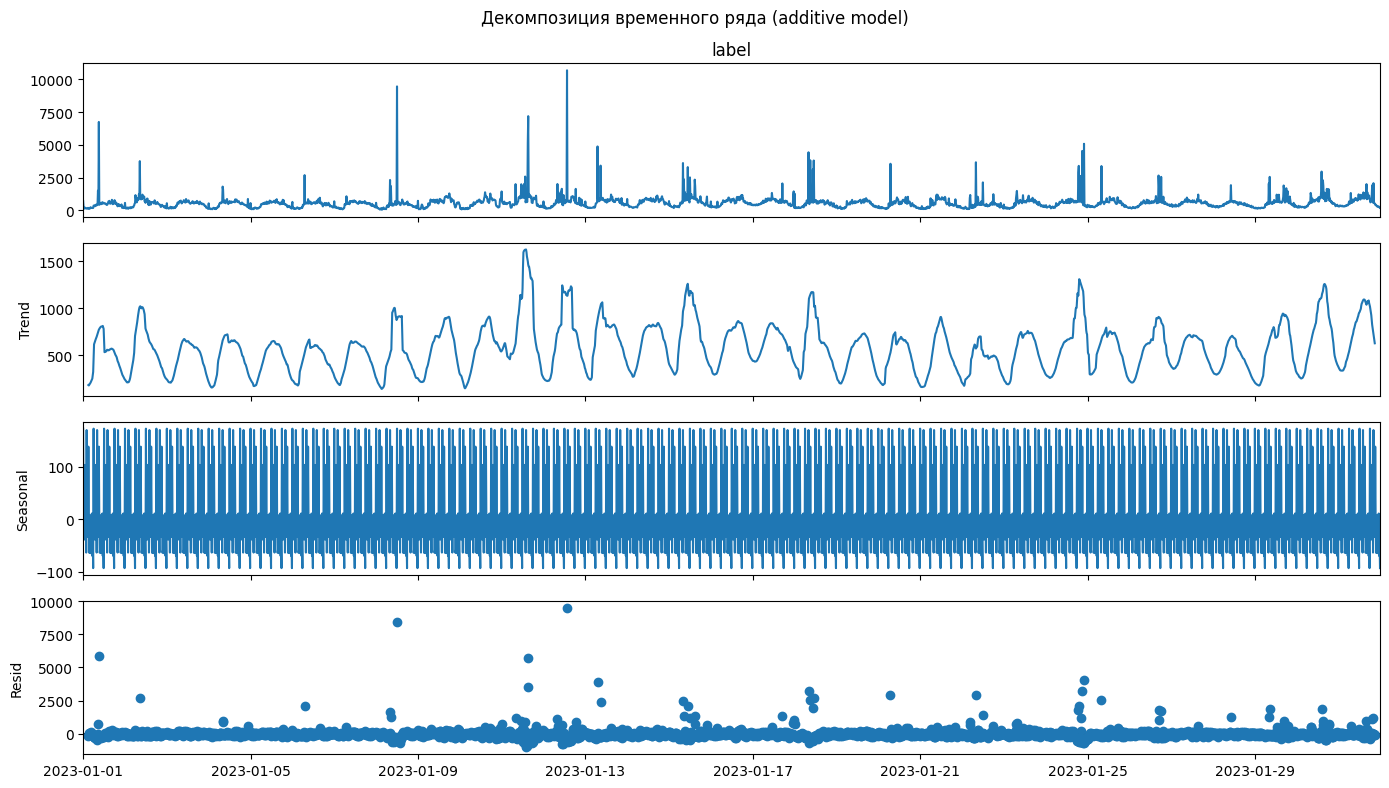

In [70]:

# --- 2. Декомпозиция ---
result = seasonal_decompose(
    data['label'],
    model='additive',
    period=24   # сутки для почасовых данных
)

# --- 3. Визуализация ---
fig = result.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Декомпозиция временного ряда (additive model)', fontsize=12)
plt.tight_layout()
plt.show()


### Анализ декомпозиции временного ряда

На графике представлены четыре компоненты временного ряда, полученные с помощью аддитивной декомпозиции:

#### 1. **Исходный ряд**
- Наблюдаются регулярные пики нагрузки.
- Значения сильно варьируются, что может указывать на всплески активности пользователей.
- Присутствуют как частые мелкие колебания, так и редкие высокие всплески.

#### 2. **Trend (трендовая компонента)**
- Тренд показывает плавные изменения общего уровня активности.
- Видны регулярные «волны», которые отражают циклическое изменение нагрузки в течение дней.
- После резких пиков тренд постепенно возвращается к среднему уровню.

#### 3. **Seasonal (сезонная компонента)**
- Чётко выраженная сезонность с фиксированным периодом.
- Повторяющиеся циклы указывают на типичное поведение пользователей в течение суток.
- Амплитуда сезонности стабильна — это подтверждает правильный выбор аддитивной модели.

#### 4. **Residual (остатки)**
- Остатки представляют случайные отклонения от тренда и сезонности.
- Большая часть точек находится около нуля — модель хорошо объясняет ряд.
- Сильные выбросы соответствуют редким аномально высоким значениям исходного ряда (например, пиковым событиям или всплескам активности).

### Вывод
Декомпозиция показала, что временной ряд состоит из:
- выраженной суточной сезонности,
- плавно меняющегося тренда,
- редких аномальных скачков нагрузки.

Это помогает лучше понять структуру данных и подготовить ряд к моделированию, прогнозированию или поиску аномалий.


### Проверка стационарности временного ряда

Проверка стационарности — важный этап анализа временных рядов, поскольку многие методы моделирования (например, ARIMA) предполагают работу именно со стационарными данными.

Стационарный ряд обладает следующими свойствами:
- постоянное среднее,
- постоянная дисперсия,
- отсутствие долгосрочного тренда,
- структура колебаний не меняется со временем.

Для проверки используется тест Дики–Фуллера (ADF-test):
- **H₀:** ряд нестационарен (имеет тренд или дрейф);
- **H₁:** ряд стационарен.

Если p-value ≤ 0.05 → отвергаем H₀ → ряд **стационарен**.

В результате теста для нашего ряда получено p-value = 0.0000, что значительно ниже 0.05 — это означает, что ряд можно считать стационарным и он подходит для моделирования алгоритмами, которые требуют стационарности.


In [71]:
result = adfuller(data['label'])

# вывод результата
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

# интерпретация результатов
if result[1] <= 0.05:
    print("\n Ряд стационарен (отвергаем H0)")
else:
    print("\n⚠️ Ряд НЕстационарен (не отвергаем H0)")

ADF Statistic: -10.218298
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

 Ряд стационарен (отвергаем H0)


In [72]:
# выводим последние n дней
n_days = 7
n = 4 * 24 * n_days
data_fill = data.iloc[-n:,:] 

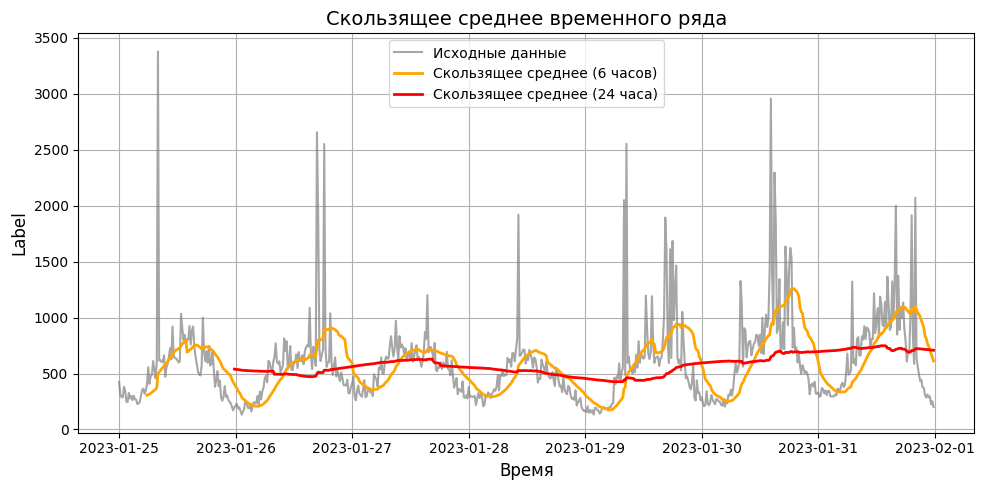

In [73]:
# применяем скользящее среднее
# ряд с интервалом 15 минут → 6 часов = 24 точки, 24 часа = 96 точек
data_fill['MA_6h'] = data_fill['label'].rolling(window=24).mean()
data_fill['MA_24h'] = data_fill['label'].rolling(window=96).mean()

# --- 3. Визуализация ---
plt.figure(figsize=(10, 5))
plt.plot(data_fill.index, data_fill['label'], label='Исходные данные', color='gray', alpha=0.7)
plt.plot(data_fill.index, data_fill['MA_6h'], label='Скользящее среднее (6 часов)', color='orange', linewidth=2)
plt.plot(data_fill.index, data_fill['MA_24h'], label='Скользящее среднее (24 часа)', color='red', linewidth=2)

plt.title('Скользящее среднее временного ряда', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Скользящее среднее временного ряда

На графике показаны:
- **серым** — исходные почасовые данные по показателю *Label*;
- **оранжевым** — скользящее среднее с окном **6 часов** (сглаживает локальные колебания, но хорошо отражает краткосрочную динамику);
- **красным** — скользящее среднее с окном **24 часа** (показывает суточный тренд).

Основные наблюдения:
- Исходный ряд содержит много шумовых колебаний и резких пиков нагрузки.
- Скользящее среднее с окном 6 часов сглаживает одиночные выбросы, но всё ещё реагирует на локальные изменения.
- Суточное скользящее среднее (24 часа) показывает более плавный тренд: общая динамика ряда остаётся относительно стабильной, без ярко выраженного постоянного роста или падения.
- Отдельные высокие пики в исходных данных не меняют долгосрочный тренд, но важны как потенциальные аномалии для дальнейшего анализа.

Использование скользящего среднего помогает уменьшить влияние шума и лучше увидеть общую тенденцию изменения показателя во времени.


### Анализ автокорреляции временного ряда

Для временного ряда дополнительно построены графики:
- ACF (Autocorrelation Function) — показывает, насколько текущие значения ряда связаны со своими прошлыми значениями на разных лагах.
- PACF (Partial Autocorrelation Function) — показывает «чистую» связь между значением ряда и его лагами с учётом промежуточных лагов.

Зачем это нужно:
- по ACF можно увидеть наличие сезонности и общую структуру зависимости во времени;
- по PACF удобно подбирать порядок моделей ARIMA/AR (количество значимых лагов);
- высокая автокорреляция на лагах, кратных 24, подтверждает суточную сезонность ряда.

Анализ этих графиков помогает выбрать подходящую модель для прогнозирования и лучше понять временную структуру данных.


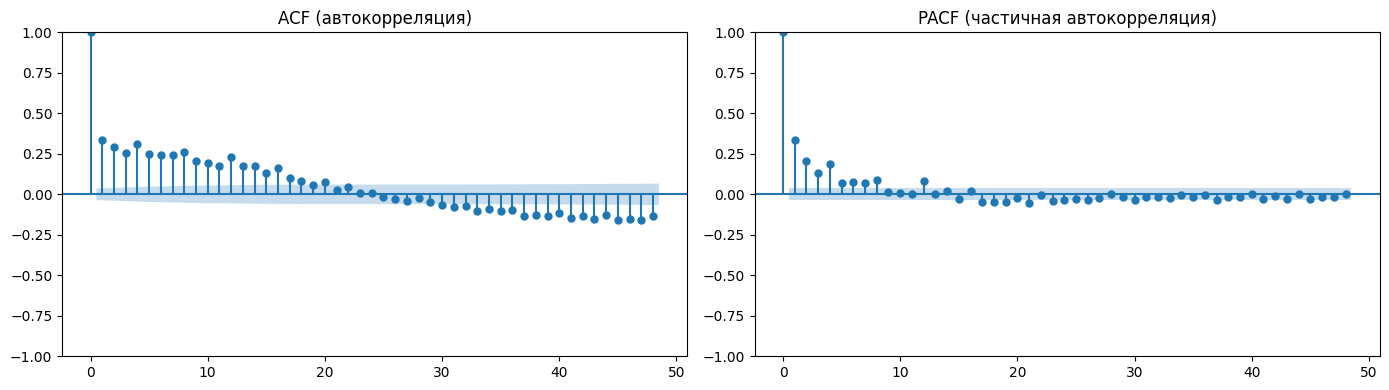

In [74]:
series = data['label']  # наш временной ряд

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF — автокорреляционная функция
plot_acf(series, lags=48, ax=axes[0])
axes[0].set_title('ACF (автокорреляция)')

# PACF — частичная автокорреляция
plot_pacf(series, lags=48, ax=axes[1])
axes[1].set_title('PACF (частичная автокорреляция)')

plt.tight_layout()
plt.show()

### Анализ автокорреляции временного ряда

На графиках представлены:

- ACF (автокорреляция) — показывает зависимость значений ряда от его прошлых значений на разных лагах.
- PACF (частичная автокорреляция) — показывает «чистый» вклад каждого лага с учётом промежуточных лагов.

Основные наблюдения:

- В ACF значение на малых лагах (особенно лаг 1) очень высокое и далее медленно убывает.  
  Это говорит о сильной зависимости текущего значения от недавних значений и «инерционности» ряда.
- В PACF ярко выделяется значимый первый лаг, а остальные лаги находятся близко к нулю (в пределах доверительных интервалов).  

### Как автокорреляция помогает выявлять временные зависимости?

Использование автокорреляции помогает в следующих задачах:

1. Выявление сезонности.  
   Если значения повторяются через фиксированные интервалы (например, каждую неделю или месяц), автокорреляция покажет пики на соответствующих лагах. Это помогает определить периодичность процессов.

2. Определение трендов.  
   Высокая автокорреляция на малых лагах часто указывает на наличие тренда: значения постепенно растут или падают, и каждое следующее значение коррелирует с предыдущими.

3. Обнаружение цикличности.  
   Автокорреляция позволяет увидеть циклы, которые не являются строгой сезонностью, но повторяются в данных с разной интенсивностью.

4. Оценка инерционности системы.  
   Если значения временного ряда сильно зависят от предыдущих, система обладает инерцией. Это важно, например, для прогнозирования нагрузки, продаж, активности пользователей и т. д.

5. Подготовка данных для моделей прогнозирования.  
   Зная автокорреляцию, можно понять, какие лаги стоит включить в модели (например, ARIMA), чтобы улучшить качество прогноза.

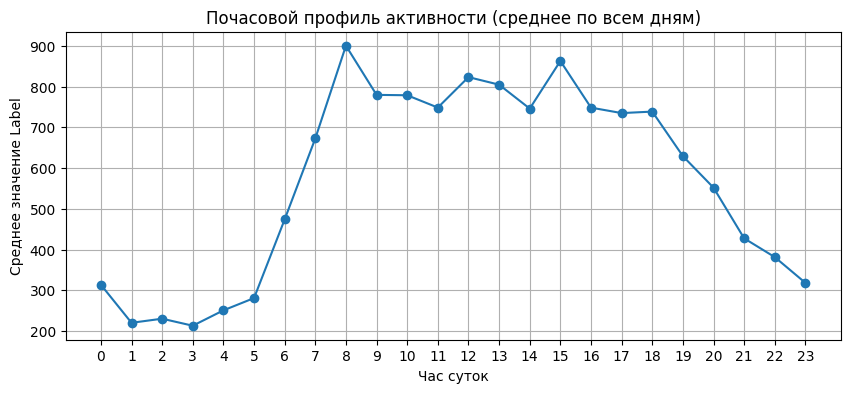

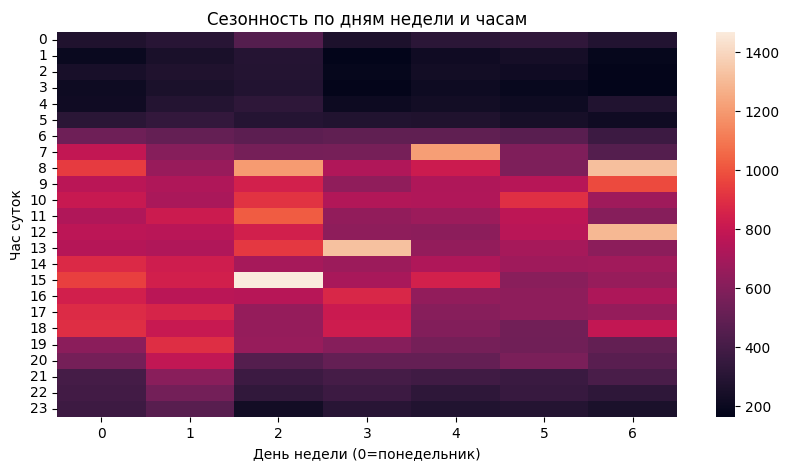

In [75]:
# почасовая сезонность (среднее по всем дням)
hourly_mean = data['label'].groupby(data.index.hour).mean()

plt.figure(figsize=(10, 4))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.xticks(range(0, 24))
plt.title('Почасовой профиль активности (среднее по всем дням)')
plt.xlabel('Час суток')
plt.ylabel('Среднее значение Label')
plt.grid(True)
plt.show()

# сезонность "день недели × час" (тепловая карта)
dow_hour_mean = data['label'].groupby(
    [data.index.dayofweek, data.index.hour]
).mean().unstack(0)  # строки — часы, столбцы — дни недели

plt.figure(figsize=(10, 5))
sns.heatmap(dow_hour_mean, annot=False)
plt.title('Сезонность по дням недели и часам')
plt.xlabel('День недели (0=понедельник)')
plt.ylabel('Час суток')
plt.show()

### Анализ сезонности

На графиках показана сезонность показателя *Label* в разрезе часов суток и дней недели.

#### Почасовой профиль активности

- В ночные часы с 0 до 4 среднее значение *Label* минимально (≈ 220–280) — трафик почти отсутствует.
- Начиная примерно с 5–6 часов активность резко растёт.
- Максимальные значения наблюдаются в утренние и дневные часы (7–15) — среднее значение *Label* достигает 800–900.
- После 16–17 часов начинается постепенное снижение нагрузки.
- К позднему вечеру (после 20 часов) значения снова приближаются к минимальным.

Это подтверждает ярко выраженную суточную сезонность: основной объём событий приходится на рабочее дневное время.

#### Сезонность по дням недели и часам

- На тепловой карте видно, что повышенная активность в дневные часы повторяется почти во все дни недели.
- На будние дни (0–4) приходится больше всего «горячих» зон — нагрузка выше и стабильнее.
- В выходные (5–6) активность в целом ниже, особенно в утренние часы, но отдельные часы всё равно могут выделяться локальными пиками.
- Самые яркие зоны сосредоточены в интервале примерно 7–15 часов, что согласуется с почасовым профилем.

Вывод: временной ряд обладает устойчивой суточной и недельной сезонностью:  
основной трафик формируется в рабочие часы будних дней, тогда как ночи и выходные характеризуются сниженной активностью.


## Обнаружение аномалий во временных рядах

Аномалии во временных рядах — это неожиданные, нетипичные значения, которые выбиваются из общего паттерна сезонности и трендов. Их важно выявлять, поскольку они могут указывать на:

- технические сбои (например, резкий провал активности)
- всплески нагрузки из-за маркетинговых кампаний или внешних событий
- аномальное поведение пользователей
- ошибки сбора данных

### Как обнаруживать аномалии?

Существует несколько распространённых подходов:

### 1. Бизнес-правило  
Мы вводим некоторые пороги на основе бизнес-правила (например число  не может превышать Х значений) 

### 2. Скользящее среднее и стандартное отклонение  
Простая и эффективная методика:  

- вычисляется скользящее среднее (MA) и стандартное отклонение (STD)  
- точка считается аномальной, если:  
  |value − MA| > k × STD, где k чаще всего берут 2 или 3


to do бизнес правило для прогнозирования на будующие дни